In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.inspection import permutation_importance

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import roc_auc_score, precision_score, \
    recall_score, f1_score, log_loss, confusion_matrix

import yaml
import json
import joblib

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [59]:
def get_metrics_classification(y_test, y_pred, y_score, name):
    """Генерация таблицы с метриками для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [60]:
config_path = '../config/params.yaml'

config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']
training = config['train']

In [61]:
preproc

{'drop_columns': ['PatientID',
  'DoctorInCharge',
  'BMI',
  'AlcoholConsumption',
  'PhysicalActivity',
  'DietQuality',
  'DiastolicBP',
  'CholesterolTotal',
  'CholesterolTriglycerides',
  'Gender',
  'EducationLevel',
  'Diabetes',
  'Disorientation',
  'Forgetfulness'],
 'map_change_columns': {'Ethnicity': {0: 'Caucasian',
   1: 'African American',
   2: 'Asian',
   3: 'Other'}},
 'one_hot_columns': ['Ethnicity'],
 'scale_columns': ['ADL',
  'Age',
  'CholesterolHDL',
  'CholesterolLDL',
  'FunctionalAssessment',
  'MMSE',
  'SleepQuality',
  'SystolicBP'],
 'passthrough_columns': ['BehavioralProblems',
  'CardiovascularDisease',
  'Confusion',
  'Depression',
  'DifficultyCompletingTasks',
  'FamilyHistoryAlzheimers',
  'HeadInjury',
  'Hypertension',
  'MemoryComplaints',
  'PersonalityChanges',
  'Smoking'],
 'raw_data_path': '../data/raw/alzheimers_disease_data.csv',
 'raw_train_path': '../data/raw/train.csv',
 'raw_test_path': '../data/raw/test.csv',
 'unique_values_path': 

In [62]:
training

{'n_folds': 3,
 'random_state': 42,
 'target_column': 'Diagnosis',
 'model_path': '../pipeline_steps/model_svc.joblib',
 'col_transform_path': '../pipeline_steps/column_transformer.joblib',
 'metrics_path': '../report/metrics.json',
 'params_path': '../report/best_params.json'}

In [63]:
data = pd.read_csv(preproc['raw_train_path'])

In [64]:
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,5531,86,0,2,1,28.155961,0,18.629164,6.535593,1.316452,...,0,0,0.232938,0,0,0,0,1,0,XXXConfid
1,6092,62,1,0,3,28.189210,1,7.763349,1.913491,6.023577,...,0,0,0.442326,0,0,0,0,0,0,XXXConfid
2,5571,75,0,0,0,25.391526,0,8.449637,9.549369,1.774418,...,0,0,4.918146,0,0,0,0,0,1,XXXConfid
3,5608,89,0,0,0,23.581751,0,1.939227,1.322465,8.758693,...,1,0,5.157190,0,1,0,0,1,0,XXXConfid
4,5344,76,1,0,2,38.768590,1,9.013919,8.296794,7.892595,...,0,0,9.413984,0,0,0,0,1,0,XXXConfid


Сохраним уникальные значения, которые будем использовать для предсказания на новых данных при сравнении признаков (также они понадобятся во фронтенд-части)

In [65]:
def save_unique_train_data(data: pd.DataFrame, drop_columns: list,
                           map_change_columns: dict,
                           target_column: str,
                           unique_values_path: str) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    df = data.drop(columns=drop_columns + [target_column], axis=1)
    df.replace(map_change_columns, inplace=True)
    # создаем словарь с уникальными значениями
    dict_unique = {key: df[key].unique().tolist() for key in df.columns}
    
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [66]:
preproc["unique_values_path"]

'../data/processed/unique_values.json'

In [67]:
save_unique_train_data(
    data=data,
    drop_columns=preproc["drop_columns"],
    map_change_columns=preproc["map_change_columns"],
    target_column=preproc["target_column"],
    unique_values_path=preproc["unique_values_path"],
)

# Preprocessing

In [68]:
data.drop(preproc['drop_columns'], axis=1, inplace=True)

In [70]:
data.replace(preproc['map_change_columns'], inplace=True)

In [72]:
X = data.drop(preproc['target_column'], axis=1)
y = data[preproc['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=preproc['test_size'],
    stratify=y,
    random_state=preproc['random_state'])

In [74]:
transformers_list = [
    ('encode', OneHotEncoder(dtype='int', drop='first'), preproc['one_hot_columns']),
    ('scale', StandardScaler(), preproc['scale_columns']),
    ('skip', 'passthrough', preproc['passthrough_columns'])
]
column_transformer = ColumnTransformer(transformers_list, verbose_feature_names_out=False)

transformed_raw_train = column_transformer.fit_transform(X_train)
transformed_raw_test = column_transformer.transform(X_test)

X_train_new = pd.DataFrame(
   transformed_raw_train, 
    columns=column_transformer.get_feature_names_out()
)
X_test_new = pd.DataFrame(
    transformed_raw_test, 
    columns=column_transformer.get_feature_names_out()
)

In [75]:
column_transform_path = training['col_transform_path']

# сохраняем обученный column transformer
joblib.dump(column_transformer, column_transform_path)

['../pipeline_steps/column_transformer.joblib']

In [76]:
X_train_new.head(2)

,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Other,ADL,Age,CholesterolHDL,CholesterolLDL,FunctionalAssessment,MMSE,SleepQuality,...,CardiovascularDisease,Confusion,Depression,DifficultyCompletingTasks,FamilyHistoryAlzheimers,HeadInjury,Hypertension,MemoryComplaints,PersonalityChanges,Smoking
0,0.0,1.0,0.0,-1.283957,1.335275,-1.409521,0.519360,0.009385,-0.461879,1.612083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,-1.379728,0.335394,1.153426,-0.446266,0.955700,1.597153,-1.549908,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Baselines

In [77]:
lr = LogisticRegression(class_weight='balanced', 
                        random_state=training['random_state'])

lr.fit(X_train_new, y_train)

y_pred_test = lr.predict(X_test_new)
y_proba_test = lr.predict_proba(X_test_new)
y_pred_train = lr.predict(X_train_new)
y_proba_train = lr.predict_proba(X_train_new)

metrics = get_metrics_classification(y_test,
                                     y_pred_test,
                                     y_proba_test,
                                     name='Logistic_regression_test')

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_train,
                               y_pred_train,
                               y_proba_train,
                               name='Logistic_regression_train')
])
metrics

,model,ROC_AUC,Precision,Recall,f1,Logloss
0,Logistic_regression_test,0.895178,0.713235,0.795082,0.751938,0.399463
0,Logistic_regression_train,0.915798,0.751371,0.845679,0.795741,0.373769


In [78]:
svc = SVC(class_weight='balanced',
          probability=True,
          random_state=training['random_state'])

svc.fit(X_train_new, y_train)

y_pred_test = svc.predict(X_test_new)
y_proba_test = svc.predict_proba(X_test_new)
y_pred_train = svc.predict(X_train_new)
y_proba_train = svc.predict_proba(X_train_new)

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_proba_test,
                               name='SVC_test')
])

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_train,
                               y_pred_train,
                               y_proba_train,
                               name='SVC_train')
])
metrics

,model,ROC_AUC,Precision,Recall,f1,Logloss
0,Logistic_regression_test,0.895178,0.713235,0.795082,0.751938,0.399463
0,Logistic_regression_train,0.915798,0.751371,0.845679,0.795741,0.373769
0,SVC_test,0.907750,0.792000,0.811475,0.801619,0.358180
0,SVC_train,0.968259,0.866920,0.938272,0.901186,0.224579


В данной задаче лучше ориентироваться на recall, так как при диагностике заболеваний ошибка второго рода страшнее, чем ошибка первого рода: ложноположительный диагноз не так страшен, как ложноотрицательный. \
Recall выше в модели SVM, однако она и переобучается сильнее, чем логистическая регрессия. Выберем в качестве бейзлайна SVC и попробуем снизить переобучение с помощью подбора гиперпараметров.

# Tuning

In [79]:
parameters_grid = {
    'kernel': ['rbf'],
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3, 2, num=10),
    'gamma': np.logspace(-3, 2, num=10),
    'probability': [True],
    'class_weight': ['balanced'],
    'random_state': [training['random_state']]
}

svc = SVC()
cv = StratifiedKFold(n_splits=training['n_folds'],
                     shuffle=True,
                     random_state=training['random_state'])

grid_cv = GridSearchCV(svc,
                       parameters_grid,
                       scoring='recall',
                       cv=cv,
                       verbose=1)

In [80]:
grid_cv.fit(X_train_new, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'class_weight': ['balanced'],
                         'gamma': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'kernel': ['rbf'], 'probability': [True],
                         'random_state': [42]},
             scoring='recall', verbose=1)

In [82]:
grid_cv.best_params_

{'C': 7.742636826811277,
 'class_weight': 'balanced',
 'gamma': 0.01291549665014884,
 'kernel': 'rbf',
 'probability': True,
 'random_state': 42}

In [83]:
grid_cv.best_score_

0.8580246913580248

# Обучение модели с лучшими гиперпараметрами

In [84]:
svc = SVC(**grid_cv.best_params_)
svc.fit(X_train_new, y_train)

y_pred_test = svc.predict(X_test_new)
y_proba_test = svc.predict_proba(X_test_new)
y_pred_train = svc.predict(X_train_new)
y_proba_train = svc.predict_proba(X_train_new)

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_proba_test,
                               name='SVC_tune_test')
])

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_train,
                               y_pred_train,
                               y_proba_train,
                               name='SVC_tune_train')
])
metrics

,model,ROC_AUC,Precision,Recall,f1,Logloss
0,Logistic_regression_test,0.895178,0.713235,0.795082,0.751938,0.399463
0,Logistic_regression_train,0.915798,0.751371,0.845679,0.795741,0.373769
0,SVC_test,0.907750,0.792000,0.811475,0.801619,0.358180
0,SVC_train,0.968259,0.866920,0.938272,0.901186,0.224579
0,SVC_tune_test,0.906587,0.781250,0.819672,0.800000,0.366498
0,SVC_tune_train,0.943088,0.805195,0.893004,0.846829,0.293149


С помощью тюнинга SVC удалось немного увеличить recall на тесте и заметно снизить переобучение.

# Post-analysis

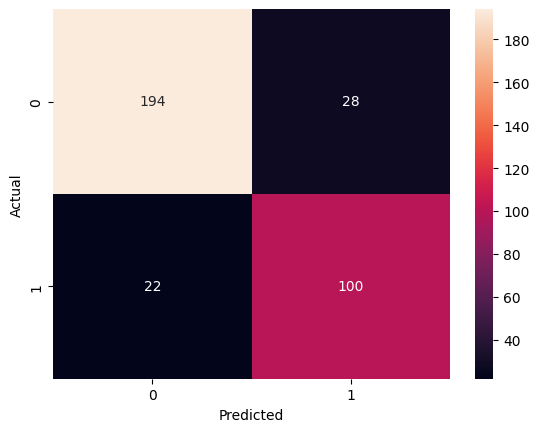

In [86]:
# матрица ошибок confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f');
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(svc,
                              X_test_new,
                              y_test,
                              random_state=42,
                              n_repeats=15)
perm_df = pd.DataFrame({
    'feature': X_test_new.columns,
    'value': perm['importances_mean']
}).sort_values(by='value', ascending=False)

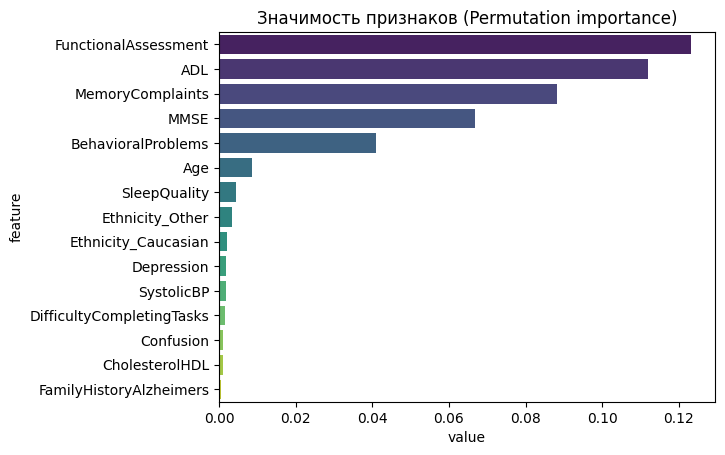

In [88]:
plt.figure()
sns.barplot(data=perm_df[:15], x='value', y='feature', palette='viridis')
plt.title('Значимость признаков (Permutation importance)');

Самыми значимыми для модели признаками оказались функциональная оценка Functional Assessment, оценка активности повседневной жизни ADL, наличие жалоб на память, оценка по краткой шкале оценки психического состояния MMSE, наличие поведенческих расстройств и возраст. Также достаточно важными признаками являются качество сна, этническая принадлежность, наличие депрессии, систолическое давление и наличие трудностей с выполнением задач. Остальные признаки оказались менее значимыми.

In [89]:
def save_metrics(y_test: np.array, y_pred: np.array, y_proba: np.array,
                 metrics_path: str) -> Dict:
    dict_metrics = {
        'roc_auc': round(roc_auc_score(y_test, y_proba[:, 1]), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'logloss': round(log_loss(y_test, y_proba), 3)
    }

    with open(metrics_path, 'w') as f:
        json.dump(dict_metrics, f)

    return dict_metrics

In [90]:
# сохранение метрик
save_metrics(
    y_test,
    y_pred_test,
    y_proba_test,
    training['metrics_path'])

{'roc_auc': 0.907,
 'precision': 0.781,
 'recall': 0.82,
 'f1': 0.8,
 'logloss': 0.366}

In [91]:
# сохранение лучших гиперпараметров
best_params = training['params_path']

with open(best_params, 'w') as f:
    json.dump(grid_cv.best_params_, f)

In [92]:
# сохранение модели
model_path = training['model_path']

joblib.dump(svc, model_path)

['../pipeline_steps/model_svc.joblib']

In [93]:
# check
with open(training['metrics_path']) as json_file:
    metrics = json.load(json_file)
metrics

{'roc_auc': 0.907,
 'precision': 0.781,
 'recall': 0.82,
 'f1': 0.8,
 'logloss': 0.366}

In [95]:
model = joblib.load(model_path)
model

SVC(C=7.742636826811277, class_weight='balanced', gamma=0.01291549665014884,
    probability=True, random_state=42)